In [1]:
from IPython import get_ipython 
from nbformat import read

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import os 
path = os.path.dirname(os.path.realpath('ex1'))
import sys 
sys.path.insert (0, path) 
import searchEngine as se

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/amparoalias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_tweets = se.df_tweets

## Ranking of the queries with tf-idf

In [ ]:
results = userInteraction(df_tweets)
totalresults = totalresults.append(results)

In [ ]:
totalresults.to_csv("../other_outputs/rq1b.tsv", sep="\t")

## Word2Vec

#### Training the model of word2vec

In [5]:
#!pip install gensim

In [6]:
from gensim.models import Word2Vec

In [7]:
model = Word2Vec(window=5, min_count=1, workers=4,size=10)

tweets_cleaned = [se.getTerms(text) for text in df_tweets["full_text"]]
model.build_vocab(tweets_cleaned)

In [8]:
model.train(tweets_cleaned,total_examples=len(tweets_cleaned),epochs=10)

(2289013, 2528250)

#### Transformation of tweets and the query

In [9]:
def tweet2vec(text,word2vec):
    for i,word in enumerate(text):
        #print(word)
    
        word_vector = word2vec[word]
        #print(word_vector.shape)
        if i  > 0:
            vectors = np.concatenate([vectors,word_vector])
        if i == 0:
            vectors = word_vector  
    return vectors.reshape(len(text),-1).mean(axis=0)


In [10]:
def query2vec(query, word2vec):
    query=se.getTerms(query)
    for i,word in enumerate(query):
        #print(word)
    
        word_vector = word2vec[word]
        #print(word_vector.shape)
        if i  > 0:
            vectors = np.concatenate([vectors,word_vector])
        if i == 0:
            vectors = word_vector  
    return vectors.reshape(len(query),-1).mean(axis=0)


In [11]:
representation = [tweet2vec(items,model) for items in tweets_cleaned]
embeded_tweets = np.array(representation)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


In [12]:
df_tweets['embeded_tweets'] = list(embeded_tweets)

In [18]:
def scoring(model, tweets_cleaned,embeded_tweets):
    print("\nHow many returned tweets you want?")
    top = input()
    top = int(top)
    
    print("\nInsert your query:")
    query_input = input()
    
    
    
    #Transform query
    query = query2vec(query_input, model)
    
    #cosine similarity
    docScores=[ [np.dot(curDocVec, query), i] for i, curDocVec in zip(df_tweets.index,df_tweets['embeded_tweets'] )]
    docScores.sort(reverse=True)
    
    #display result:
    print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(docScores)))
    results = pd.DataFrame(columns=['for_query','tweet', 'username', 'date', 'hashtags', 'likes', 'retweets', 'url'])
    count = 0

    for scores in docScores[:top] :
        d_id = scores[1]
        results.loc[count,'for_query'] = query_input
        results.loc[count,'tweet'] = df_tweets.loc[d_id, "full_text"]
        results.loc[count,'username'] = df_tweets.loc[d_id, "user"]['screen_name']
        results.loc[count,'date'] = df_tweets.loc[d_id, "created_at"]
        results.loc[count,'hashtags'] = [df_tweets.loc[0,'entities']['hashtags'][i]['text'] for i in range(len(df_tweets.loc[0,'entities']['hashtags']))]
        results.loc[count,'likes'] = df_tweets.loc[d_id, "favorite_count"]
        results.loc[count,'retweets'] = df_tweets.loc[d_id, "retweet_count"]
        results.loc[count,'url'] = "https://twitter.com/twitter/statuses/"+str(df_tweets.loc[d_id, "id"])
        count +=1

    return results

In [19]:
totalresults = pd.DataFrame()

In [40]:
results = scoring(model, tweets_cleaned, embeded_tweets)
totalresults = totalresults.append(results)


How many returned tweets you want?
20

Insert your query:
All lives matter

Top 20 results out of 11546 for the searched query:



/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [42]:
totalresults.to_csv("../other_outputs/rq1c.tsv", sep="\t")

## TSNE

In [43]:
from sklearn.manifold import TSNE

In [44]:
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=250, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embeded_tweets))

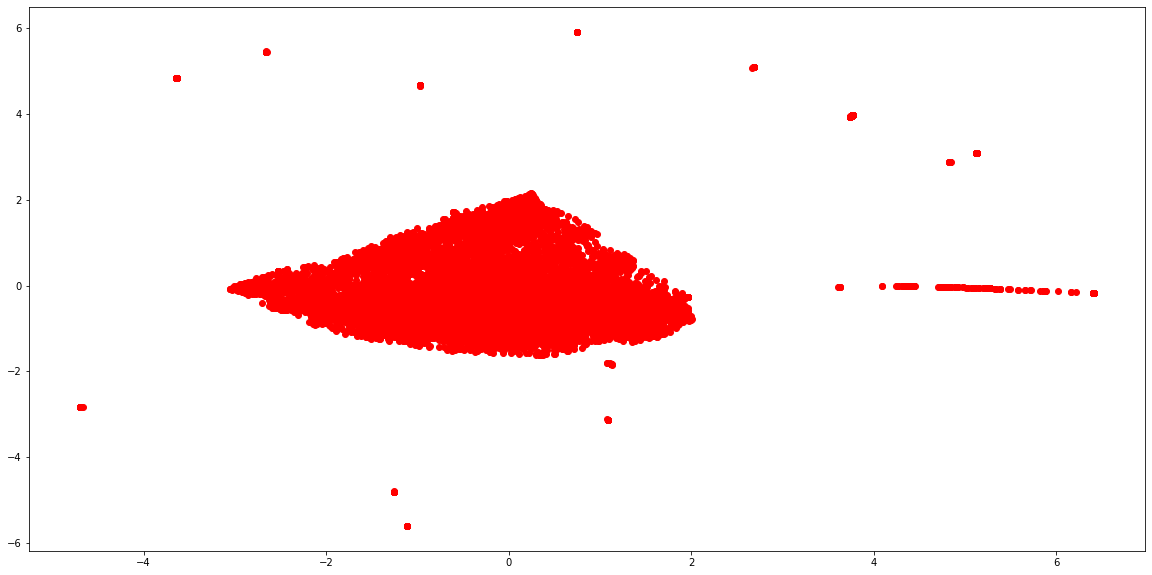

In [45]:
x = embeddings_en_2d[:, 0]
y = embeddings_en_2d[:, 1]
plt.figure(figsize=(20,10))
plt.scatter(x, y, c='red')

## Clustering

In [46]:
NUM_CLUSTERS = 2

In [47]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=0,max_iter=1000).fit(embeddings_en_2d)
df_tweets["cluster"] = kmeans.labels_


In [54]:
import nltk

In [79]:
grouped = df_tweets.groupby(by = df_tweets['cluster'])
for cluster in grouped.groups.keys():
    df = grouped.get_group(cluster)
    tweets_cleaned = [se.getTerms(text) for text in df["full_text"]]
    text = [text for text in tweets_cleaned]
    text = [text for text in text for text in text]
    freq = nltk.FreqDist(text)
    print(freq.most_common(10))
    print("\n")

[('america', 7080), ('racism', 4995), ('', 3637), ('america ', 3220), ('blm', 2278), ('peopl', 2142), ('black', 2106), ('racism ', 1807), (' amp ', 1739), ('white', 1672)]


[('replac', 495), ('america', 466), (' ', 406), ('black', 323), ('live', 323), ('matter', 301), ('church', 252), (' amp ', 248), ('sign ', 247), ('racist', 246)]


